In [1]:
import mujoco
import mediapy as media

In [3]:
# PATHS
HR_MODEL_PATH = "hello_robot_stretch/stretch.xml"
HR_URDF_PATH = 'mujo_venv/lib/python3.12/site-packages/stretch_urdf/SE3/stretch_description_SE3_eoa_wrist_dw3_tool_sg3.urdf'

In [4]:
hr_model = mujoco.MjModel.from_xml_path(HR_URDF_PATH)

ValueError: Error: resource not found via provider or OS filesystem: 'mujo_venv/lib/python3.12/site-packages/stretch_urdf/SE3/base_link_collision.STL'

In [3]:
hr_model = mujoco.MjModel.from_xml_path(HR_MODEL_PATH)
hr_data = mujoco.MjData(hr_model)

""

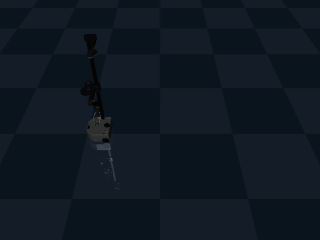

In [10]:
hr_renderer = mujoco.Renderer(hr_model)
mujoco.mj_forward(hr_model, hr_data)
hr_renderer.update_scene(hr_data)
media.show_image(hr_renderer.render())


""

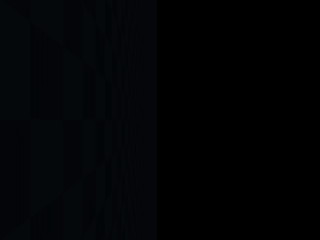

In [4]:
cam_renderer = mujoco.Renderer(hr_model)
mujoco.mj_forward(hr_model, hr_data)
cam_renderer.update_scene(hr_data, camera='camera_rgb')
media.show_image(cam_renderer.render())


In [5]:
duration = 3
fps = 60
frames = []
camera_frames = []

mujoco.mj_resetData(hr_model, hr_data)
hr_data.ctrl[0] = 10
hr_data.ctrl[7] = -2
hr_data.ctrl[6] = 1
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = False
while hr_data.time < duration:
	mujoco.mj_step(hr_model, hr_data)
	if len(frames) < hr_data.time * fps:
		cam_renderer.update_scene(hr_data, camera='camera_rgb')
		cam_pixels = cam_renderer.render()
		camera_frames.append(cam_pixels)
media.show_video(camera_frames, fps=fps)

In [1]:
import importlib.resources as importlib_resources

pkg_path = str(importlib_resources.files("stretch_urdf"))
print(pkg_path)

/home/kkatodus/hellorobot/mujoco_py/mujo_venv/lib/python3.12/site-packages/stretch_urdf


In [3]:
model_name = 'SE3' # RE1V0, RE2V0, SE3
tool_name = 'eoa_wrist_dw3_tool_sg3' # eoa_wrist_dw3_tool_sg3, tool_stretch_gripper, etc
urdf_file_path = pkg_path + f"/{model_name}/stretch_description_{model_name}_{tool_name}.urdf"
mesh_files_directory_path = pkg_path + f"/{model_name}/meshes"
print('urdf_file_path:', urdf_file_path)
print('mesh_files_directory_path:', mesh_files_directory_path)

urdf_file_path: /home/kkatodus/hellorobot/mujoco_py/mujo_venv/lib/python3.12/site-packages/stretch_urdf/SE3/stretch_description_SE3_eoa_wrist_dw3_tool_sg3.urdf
mesh_files_directory_path: /home/kkatodus/hellorobot/mujoco_py/mujo_venv/lib/python3.12/site-packages/stretch_urdf/SE3/meshes
